In [26]:
# Core libraries
import pandas as pd
import numpy as np
import json
from urllib.request import urlopen
import warnings

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd

# Scikit-learn preprocessing and imputation
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Scikit-learn models
from sklearn.linear_model import Ridge, Lasso, BayesianRidge, LinearRegression
from xgboost import XGBRegressor

# Scikit-learn model selection and evaluation
from sklearn.model_selection import (
    train_test_split,
    KFold,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    make_scorer
)

# Scikit-learn pipeline
from sklearn.pipeline import Pipeline

# Statsmodels
import statsmodels.api as sm
from statsmodels.stats.diagnostic import (
    het_breuschpagan,
    acorr_breusch_godfrey
)
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scipy
from scipy.stats import shapiro, anderson

# SHAP for model interpretation
import shap

# Function for MC

In [27]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
def MC(dataset):
    # === Load and clean data ===
    df = pd.read_excel(dataset)
    df = df[df['County'].notna()]
    target_col = '% Vaccinated'
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=[target_col])
    temp = df['FIPS'].astype(str).str.pad(5, 'left', '0')
    df = df.drop(columns=['FIPS'], errors='ignore')
    
    X = df.drop(columns=[target_col]).select_dtypes(include=[np.number])
    y = df[target_col]
    X, y = X.align(y, join='inner', axis=0)

    X = X.loc[:, X.isnull().mean() <= 0.20]
    X = X.clip(-1e3, 1e3)
    low_var_cols = X.var()[X.var() < 1e-8].index.tolist()
    X = X.drop(columns=low_var_cols)

    # === 90/10 holdout split ===
    # X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # === Hyperparameter space ===
    param_dist = {
        'n_estimators': [100, 200, 300],             # more trees, learn slowly
        'max_depth': [2, 3, 4],                      # shallower trees
        'learning_rate': [0.01, 0.03, 0.05],         # smaller steps
        'subsample': [0.6, 0.8],                     # partial row sampling
        'colsample_bytree': [0.6, 0.8],              # partial feature sampling
        'gamma': [0.1, 0.3, 0.5],                    # avoid small splits
        'reg_alpha': [0, 0.1, 0.5],                  # L1 penalty
        'reg_lambda': [1, 2, 5],                     # L2 penalty
    }


    # === Hyperparameter search: outer loop ===
    n_trials = 50
    n_iterations = 5  # Monte Carlo splits per hyperparam set

    results = []

    for t in range(n_trials):
        params = {k: np.random.choice(v) for k, v in param_dist.items()}
        print(f"\n🔍 Trial {t + 1}/{n_trials} with params: {params}")

        rmses = []
        r2s = []
        mapes = []

        # Monte Carlo iterations: inner loop
        for i in range(n_iterations):
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=0.2, random_state=i
            )
            model = XGBRegressor(random_state=42, **params)
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])

            try:
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_val)

                rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                r2 = r2_score(y_val, y_pred)
                nonzero_mask = y_val != 0
                mape = np.mean(
                    np.abs((y_val[nonzero_mask] - y_pred[nonzero_mask]) / y_val[nonzero_mask])
                ) * 100

                rmses.append(rmse)
                r2s.append(r2)
                mapes.append(mape)

            except Exception as e:
                print(f"⚠️ Iteration {i + 1} failed: {e}")

        # Average performance over Monte Carlo splits
        avg_rmse = np.mean(rmses)
        avg_r2 = np.mean(r2s)
        avg_mape = np.mean(mapes)

        print(f"✅ Avg RMSE: {avg_rmse:.2f}, Avg R²: {avg_r2:.2f}, Avg MAPE: {avg_mape:.2f}%")

        results.append({
            'rmse': avg_rmse,
            'r2': avg_r2,
            'mape': avg_mape,
            'params': params
        })

    # === Select best hyperparameters ===
    best_overall = min(results, key=lambda x: x['rmse'])
    print("\n🏆 Best Hyperparameters Across All Trials:")
    print(f"RMSE: {best_overall['rmse']:.2f}, R²: {best_overall['r2']:.2f}, MAPE: {best_overall['mape']:.2f}%")
    print(f"Params: {best_overall['params']}")

    # === Train final model on full 90% training set ===
    final_model = Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(random_state=42, **best_overall['params']))
    ])
    final_model.fit(X, y)

    # === Evaluate ===
    y_pred = final_model.predict(X)
    rmse_test = np.sqrt(mean_squared_error(y, y_pred))
    r2_train = r2_score(y, y_pred)
    n = X.shape[0]
    p = X.shape[1]
    adj_r2_train = 1 - (1 - r2_train) * (n - 1) / (n - p - 1)

    nonzero_mask_test = y != 0
    mape_test = np.mean(
        np.abs((y[nonzero_mask_test] - y_pred[nonzero_mask_test]) / y[nonzero_mask_test])
    ) * 100

    print("\n🧪 Final Test Set Performance:")
    print(f"RMSE: {rmse_test:.2f}")
    print(f"R²: {r2_train:.2f}")
    print(f"Adjusted R²: {adj_r2_train:.2f}")
    print(f"MAPE: {mape_test:.2f}%")

    # === SHAP Analysis ===
    X_scaled = final_model.named_steps['scaler'].transform(X)
    explainer = shap.TreeExplainer(final_model.named_steps['model'])
    shap_values = explainer.shap_values(X_scaled)

    shap.summary_plot(
        shap_values,
        features=pd.DataFrame(X_scaled, columns=X.columns),
        feature_names=X.columns
        #max_display=10
    )



    #--------NEW CODE---------
    # Compute mean absolute SHAP values
    mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
    
    # Create DataFrame
    shap_df = pd.DataFrame({
        'feature': X.columns,
        'mean_abs_shap': mean_abs_shap_values
    })
    
    # Sort ascending or descending
    shap_df = shap_df.sort_values(by='mean_abs_shap', ascending=True)
    
    # Take bottom 10 or top 10
    top_features_df = shap_df.tail(10)
    #top_features_df = shap_df.copy()
    
    # Assign a single color (since there is no sign)
    bar_color = 'cornflowerblue'
    
    # We’ll plot *all* features
    all_features_df = shap_df
    
    # Adjust figure height dynamically:
    # For example: 0.4 inch per feature row
    n_features = len(all_features_df)
    fig_height = max(6, n_features * 0.4)
    
    # === Plot ===
    fig, ax = plt.subplots(figsize=(6, fig_height))
    
    bars = ax.barh(
        y=all_features_df['feature'],
        width=all_features_df['mean_abs_shap'],
        color='cornflowerblue'
    )
    
    ax.axvline(0, color='gray', linewidth=1)
    ax.set_xlim(0, 3)   # You can adjust max scale here
    
    # Labels
    ax.set_xlabel("Mean Absolute SHAP Value")
    ax.set_ylabel("Feature")
    ax.set_title("All Features by Mean Absolute SHAP")
    
    # Add value labels (2 decimals)
    for bar, val in zip(bars, all_features_df['mean_abs_shap']):
        ax.text(
            val + 0.02,
            bar.get_y() + bar.get_height()/2,
            f"{val:.2f}",
            va='center',
            ha='left'
        )
    
    # Consistent margin so labels fit
    fig.subplots_adjust(left=0.4)
    
    plt.show()


    print("Top 5 Features")

    
    # === Fixed size and margin ===
    fig, ax = plt.subplots(figsize=(4,6))  # Always same size
    
    bars = ax.barh(
        y=top_features_df['feature'],
        width=top_features_df['mean_abs_shap'],
        color='cornflowerblue'
    )
    
    ax.axvline(0, color='gray', linewidth=1)
    ax.set_xlim(0, 3)  # Same scale for all plots
    
    # Labels
    ax.set_xlabel("Mean Absolute SHAP Value")
    ax.set_ylabel("Feature")
    ax.set_title("Top 10 Features by Mean Absolute SHAP")
    
    # Add value labels
    for bar, val in zip(bars, top_features_df['mean_abs_shap']):
        ax.text(
            val + 0.02,
            bar.get_y() + bar.get_height()/2,
            f"{val:.2f}",
            va='center',
            ha='left'
        )
    
    # 🚀 FIXED LEFT MARGIN
    # This *prevents long labels from squishing the bars*
    fig.subplots_adjust(left=0.4)   # Adjust if labels still get cut off
    # DO NOT use plt.tight_layout(), as it will override subplots_adjust
    
    plt.show()
    

    


    # Append predictions to dataframe
    df['Predicted'] = final_model.predict(X)
    df['Differences'] = df['Predicted'] - y
    df['FIPS'] = temp

    return df

# Pre COV Analysis on URBAN/MIXED/RURAL


🔍 Trial 1/50 with params: {'n_estimators': np.int64(200), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.5), 'reg_alpha': np.float64(0.1), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 4.48, Avg R²: 0.62, Avg MAPE: 7.75%

🔍 Trial 2/50 with params: {'n_estimators': np.int64(300), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.6), 'gamma': np.float64(0.3), 'reg_alpha': np.float64(0.5), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 4.21, Avg R²: 0.67, Avg MAPE: 7.28%

🔍 Trial 3/50 with params: {'n_estimators': np.int64(300), 'max_depth': np.int64(2), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.6), 'gamma': np.float64(0.3), 'reg_alpha': np.float64(0.5), 'reg_lambda': np.int64(5)}
✅ Avg RMSE: 4.48, Avg R²: 0.62, Avg MAPE: 7.72%

🔍 Trial 4/50 with params: {'n_estimators': np

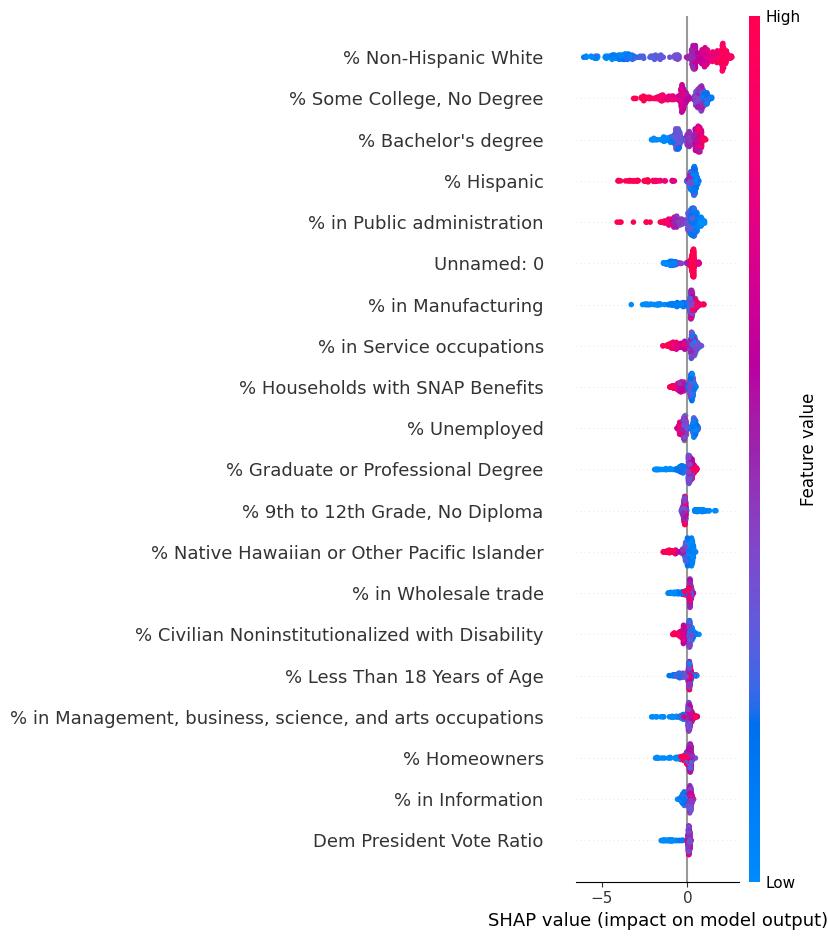

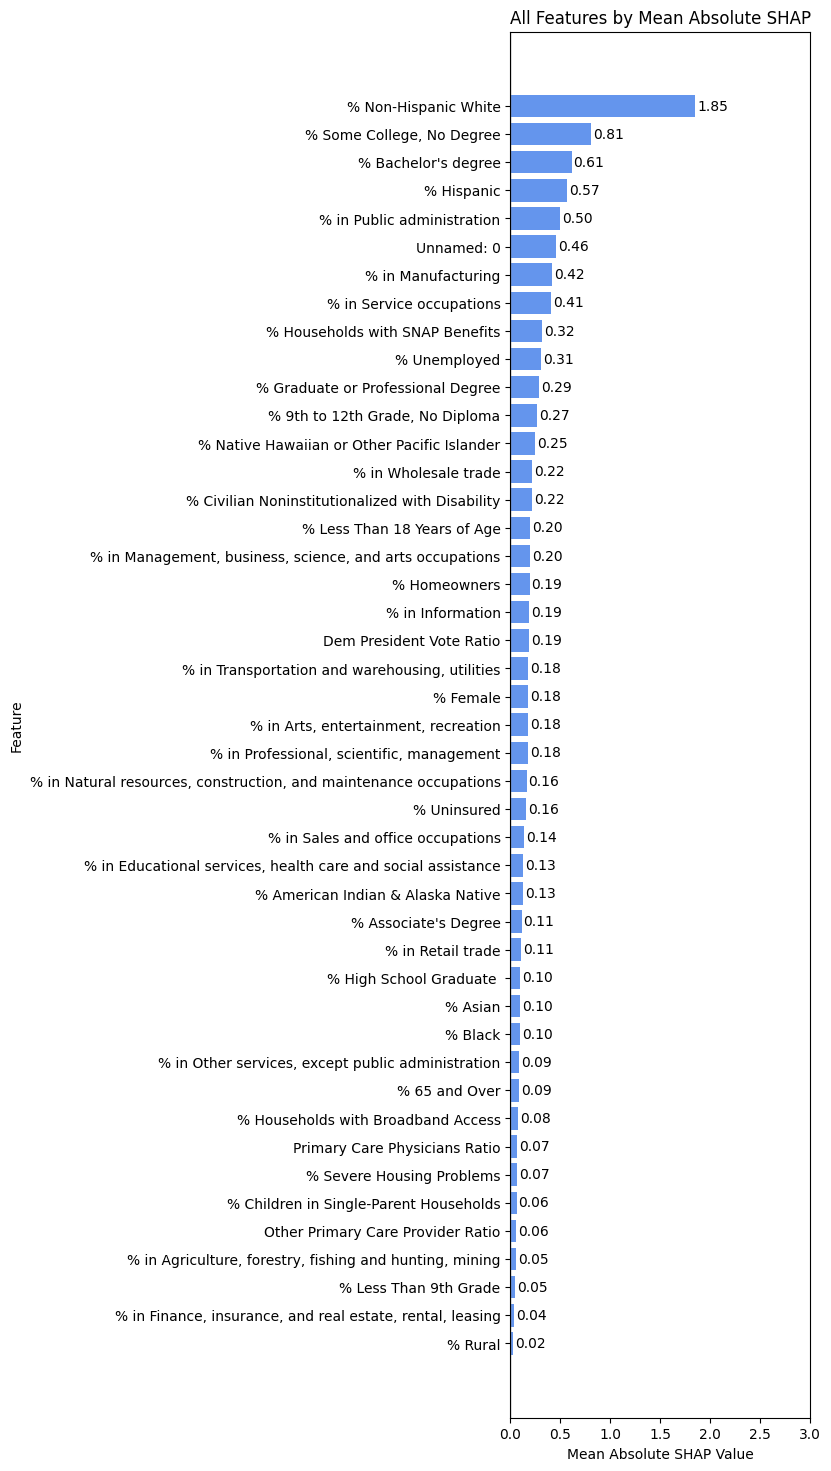

Top 5 Features


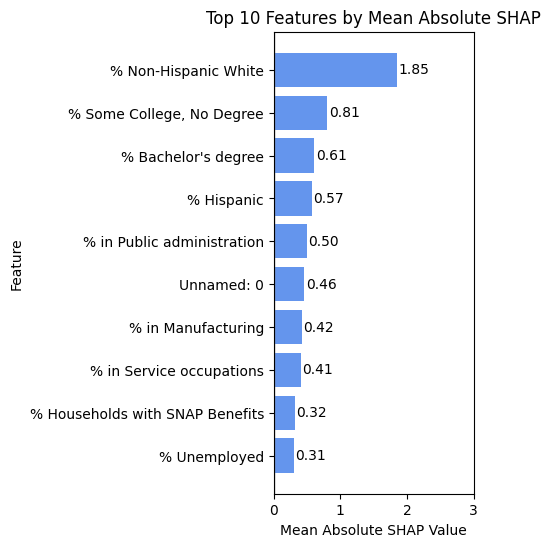

In [28]:
result1 = MC('/Users/jacobhahn/Desktop/CSUREMM 2025/PRE_COVID_ind_urban.xlsx')


🔍 Trial 1/50 with params: {'n_estimators': np.int64(300), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.05), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.1), 'reg_alpha': np.float64(0.0), 'reg_lambda': np.int64(5)}
✅ Avg RMSE: 7.01, Avg R²: 0.39, Avg MAPE: 14.63%

🔍 Trial 2/50 with params: {'n_estimators': np.int64(100), 'max_depth': np.int64(2), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.5), 'reg_alpha': np.float64(0.5), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 8.09, Avg R²: 0.19, Avg MAPE: 17.40%

🔍 Trial 3/50 with params: {'n_estimators': np.int64(300), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.1), 'reg_alpha': np.float64(0.1), 'reg_lambda': np.int64(5)}
✅ Avg RMSE: 7.13, Avg R²: 0.37, Avg MAPE: 15.09%

🔍 Trial 4/50 with params: {'n_estimators':

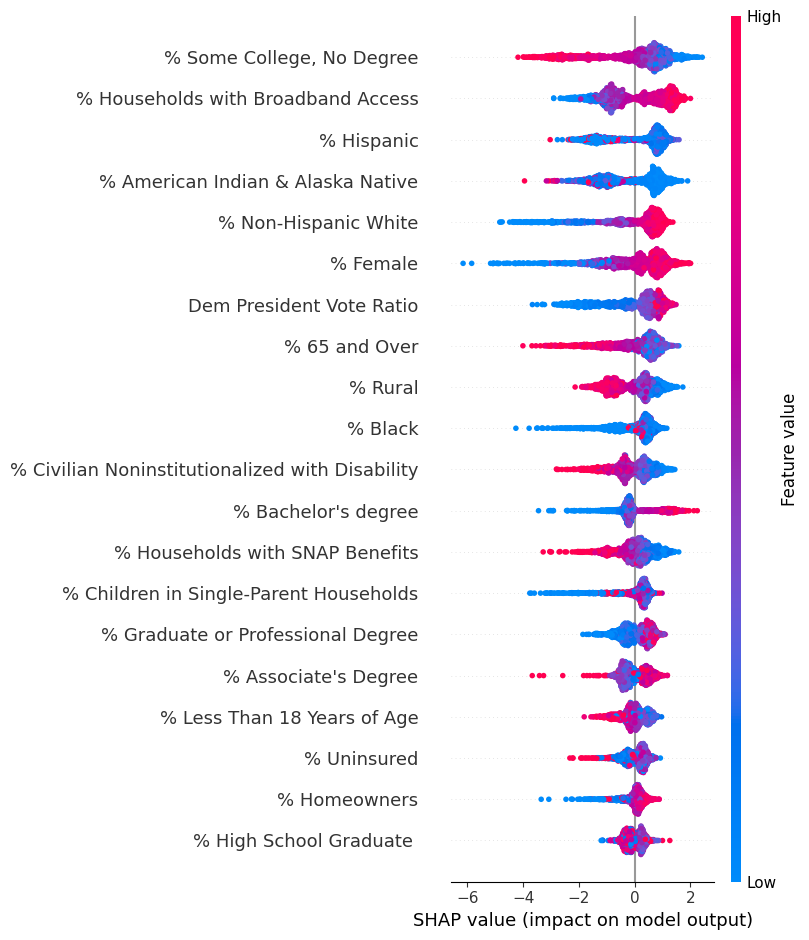

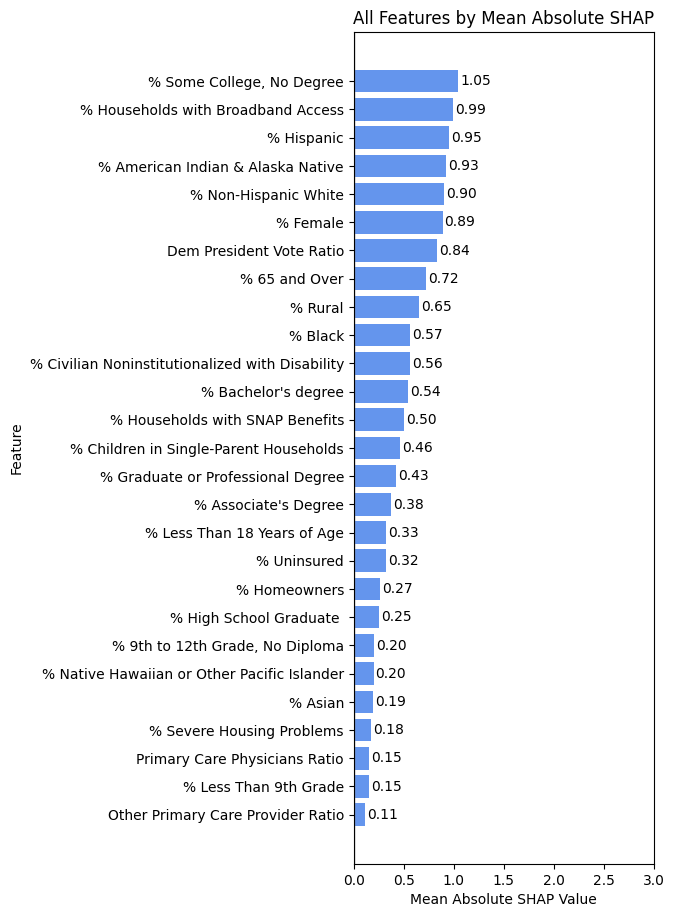

Top 5 Features


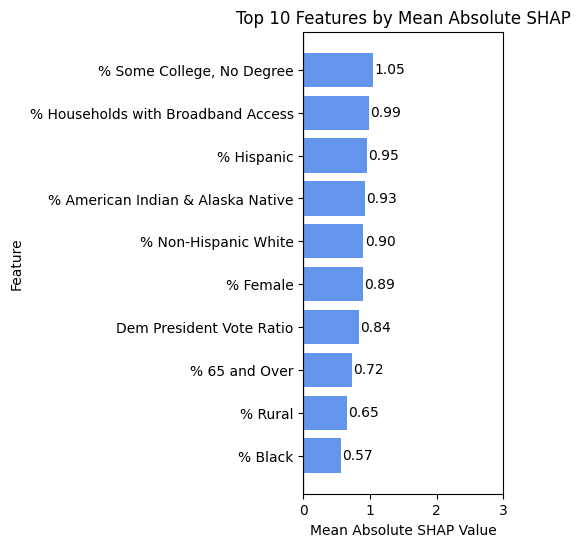

In [29]:
result2 = MC('/Users/jacobhahn/Desktop/CSUREMM 2025/PRE_COVID_ind_mix.xlsx')


🔍 Trial 1/50 with params: {'n_estimators': np.int64(300), 'max_depth': np.int64(2), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.5), 'reg_alpha': np.float64(0.0), 'reg_lambda': np.int64(5)}
✅ Avg RMSE: 9.15, Avg R²: 0.19, Avg MAPE: 23.58%

🔍 Trial 2/50 with params: {'n_estimators': np.int64(200), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.03), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.6), 'gamma': np.float64(0.5), 'reg_alpha': np.float64(0.0), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 9.11, Avg R²: 0.20, Avg MAPE: 23.08%

🔍 Trial 3/50 with params: {'n_estimators': np.int64(100), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.05), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.1), 'reg_alpha': np.float64(0.1), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 9.19, Avg R²: 0.19, Avg MAPE: 23.26%

🔍 Trial 4/50 with params: {'n_estimators':

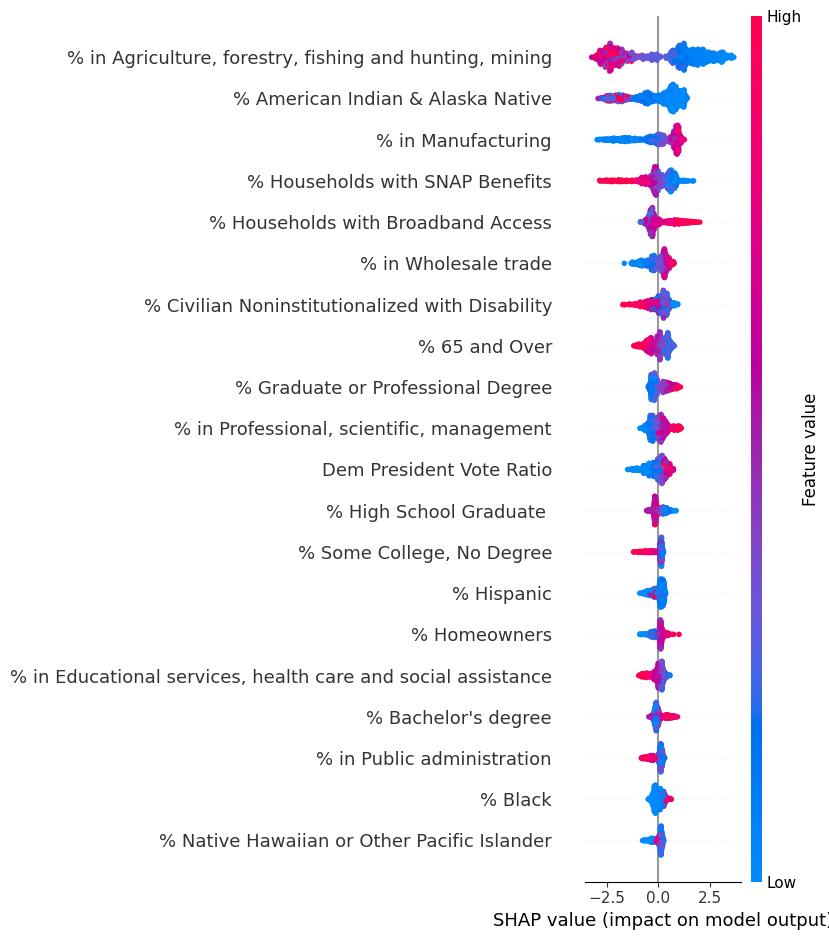

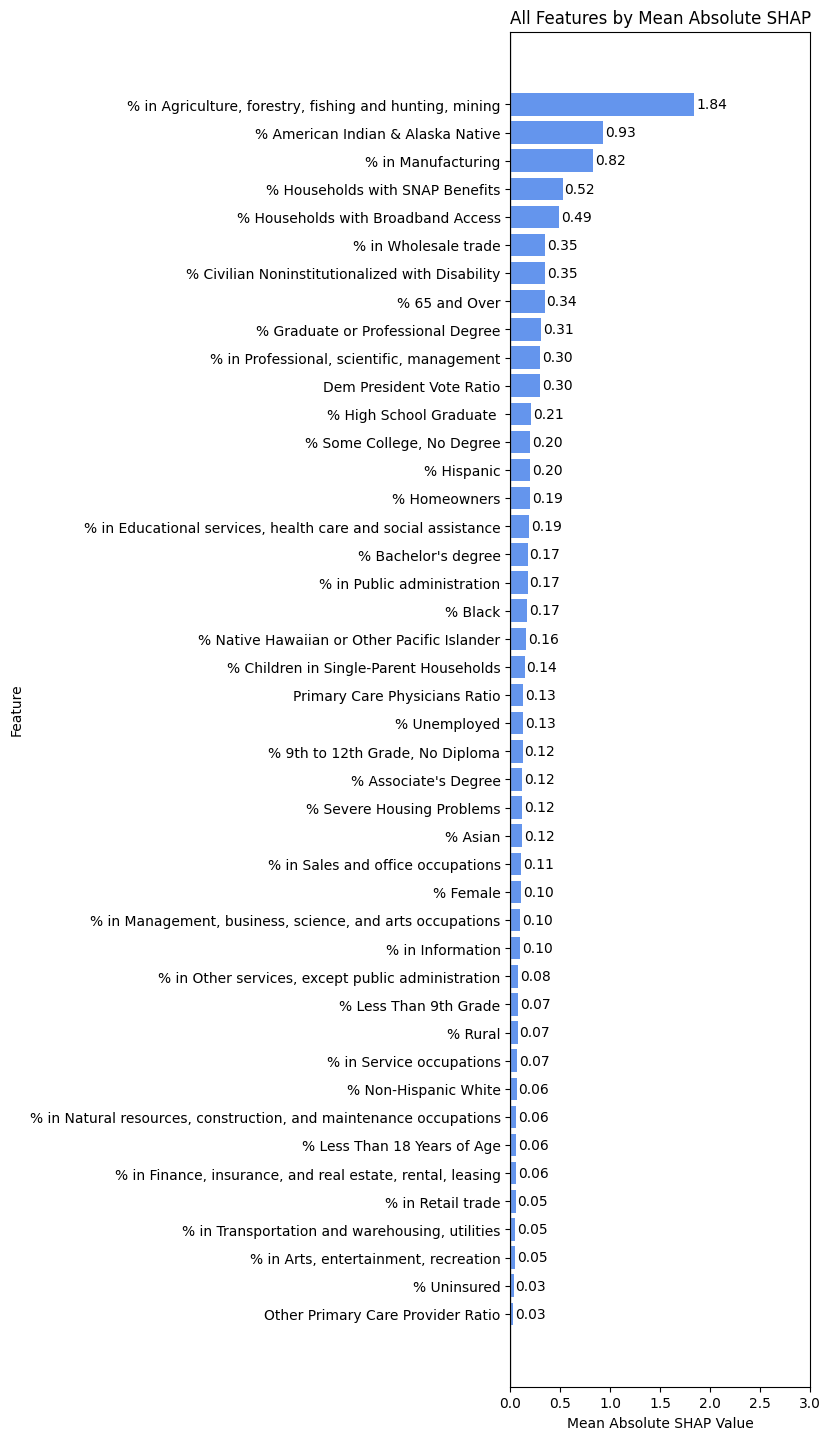

Top 5 Features


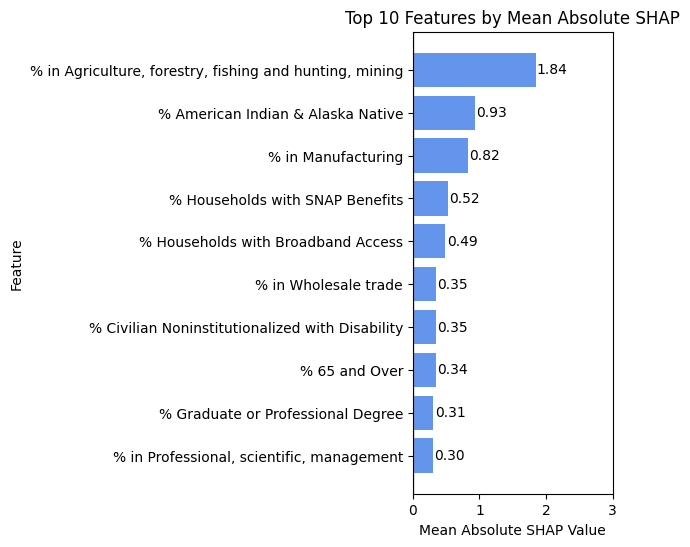

In [30]:
result3 = MC('/Users/jacobhahn/Desktop/CSUREMM 2025/PRE_COVID_ind_rural.xlsx')

# During COV Analysis on URBAN/MIXED/RURAL


🔍 Trial 1/50 with params: {'n_estimators': np.int64(200), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.03), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.6), 'gamma': np.float64(0.1), 'reg_alpha': np.float64(0.0), 'reg_lambda': np.int64(1)}
✅ Avg RMSE: 5.25, Avg R²: 0.57, Avg MAPE: 8.78%

🔍 Trial 2/50 with params: {'n_estimators': np.int64(300), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.3), 'reg_alpha': np.float64(0.0), 'reg_lambda': np.int64(5)}
✅ Avg RMSE: 5.60, Avg R²: 0.51, Avg MAPE: 9.44%

🔍 Trial 3/50 with params: {'n_estimators': np.int64(200), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.05), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.6), 'gamma': np.float64(0.3), 'reg_alpha': np.float64(0.1), 'reg_lambda': np.int64(5)}
✅ Avg RMSE: 5.27, Avg R²: 0.56, Avg MAPE: 8.76%

🔍 Trial 4/50 with params: {'n_estimators': np

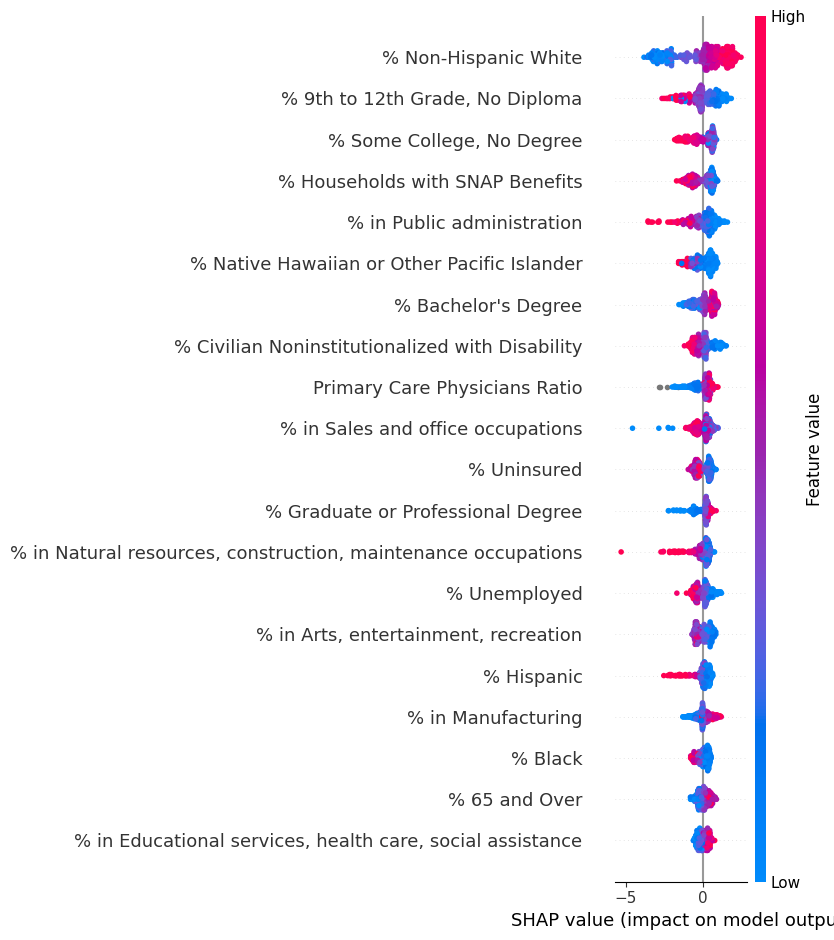

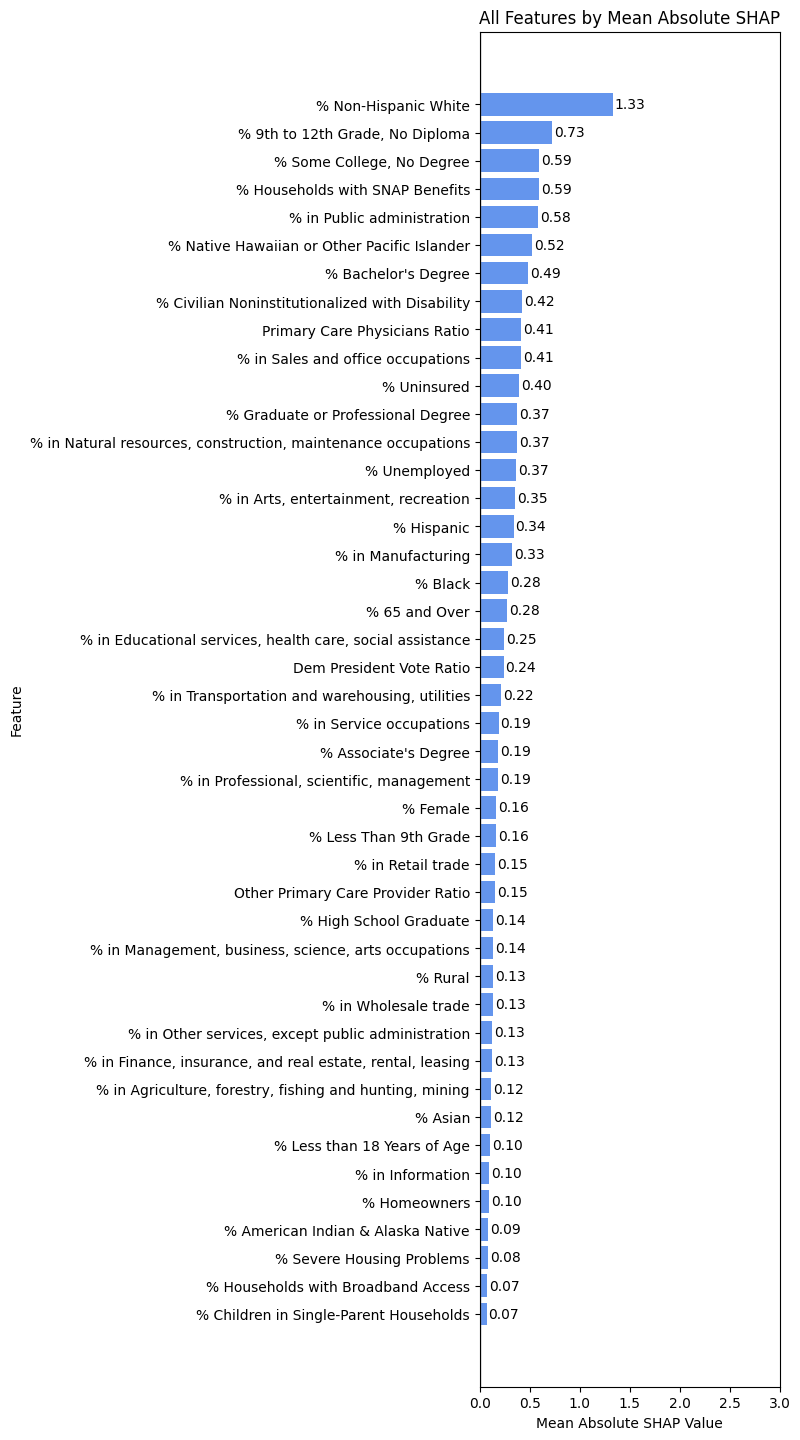

Top 5 Features


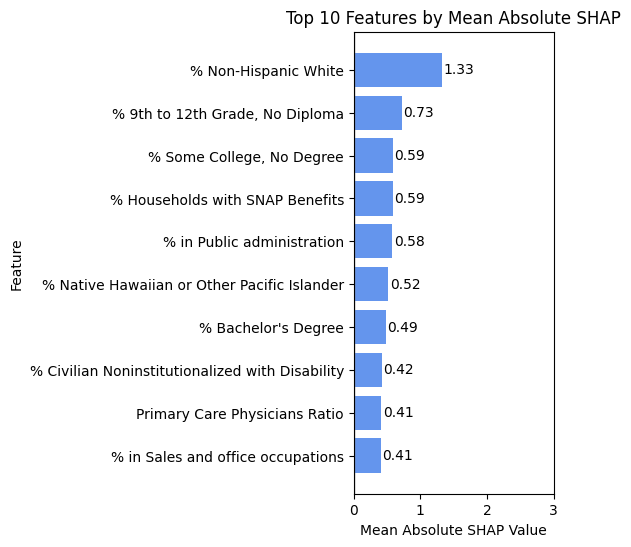

In [31]:
result4 = MC('/Users/jacobhahn/Desktop/CSUREMM 2025/DURING_COVID_ind_urban.xlsx')


🔍 Trial 1/50 with params: {'n_estimators': np.int64(100), 'max_depth': np.int64(2), 'learning_rate': np.float64(0.05), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.3), 'reg_alpha': np.float64(0.1), 'reg_lambda': np.int64(1)}
✅ Avg RMSE: 6.43, Avg R²: 0.45, Avg MAPE: 11.69%

🔍 Trial 2/50 with params: {'n_estimators': np.int64(200), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.6), 'gamma': np.float64(0.3), 'reg_alpha': np.float64(0.1), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 6.70, Avg R²: 0.40, Avg MAPE: 12.37%

🔍 Trial 3/50 with params: {'n_estimators': np.int64(300), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.03), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.6), 'gamma': np.float64(0.3), 'reg_alpha': np.float64(0.1), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 6.24, Avg R²: 0.48, Avg MAPE: 11.23%

🔍 Trial 4/50 with params: {'n_estimators':

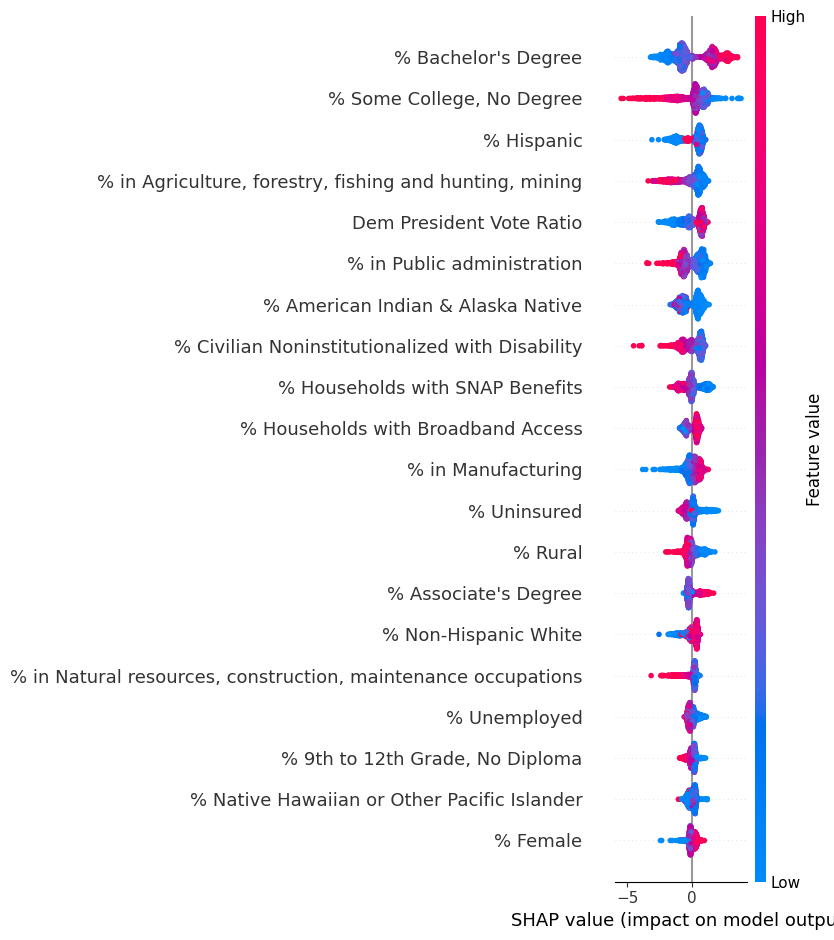

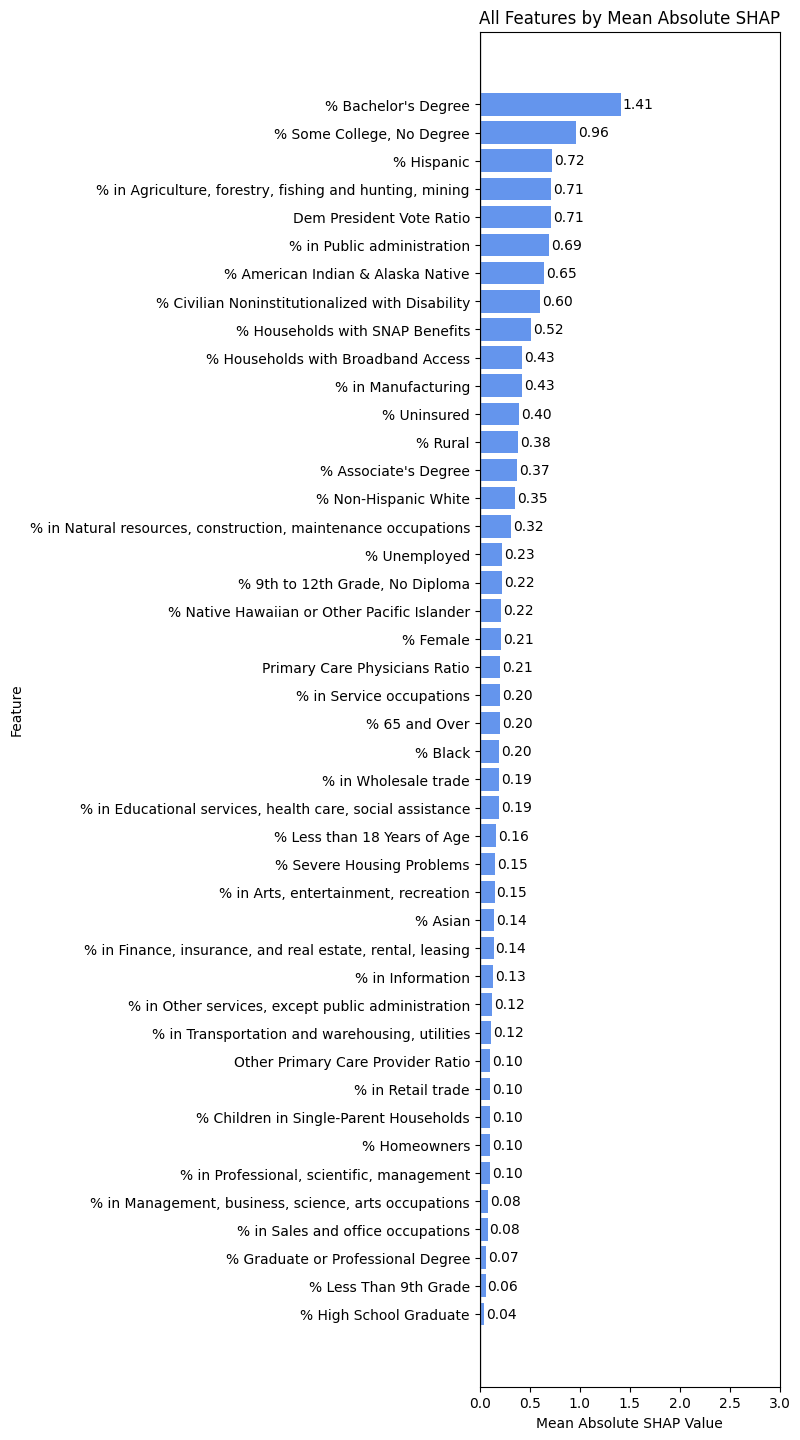

Top 5 Features


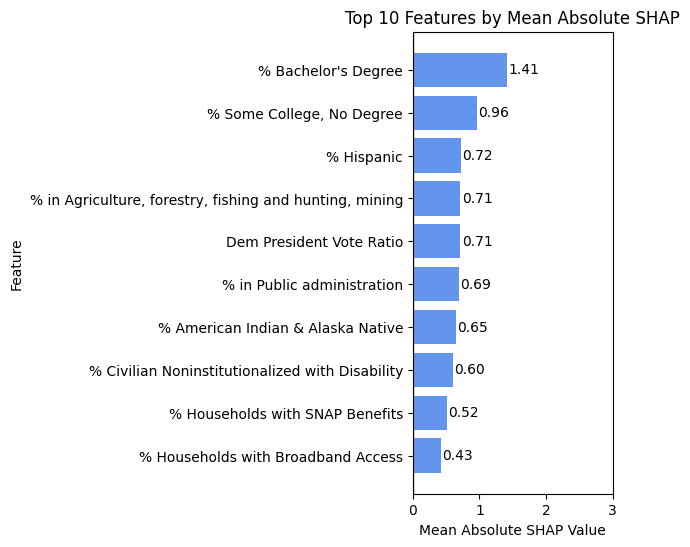

In [32]:
result5 = MC('/Users/jacobhahn/Desktop/CSUREMM 2025/DURING_COVID_ind_mix.xlsx')


🔍 Trial 1/50 with params: {'n_estimators': np.int64(200), 'max_depth': np.int64(2), 'learning_rate': np.float64(0.03), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.6), 'gamma': np.float64(0.1), 'reg_alpha': np.float64(0.1), 'reg_lambda': np.int64(5)}
✅ Avg RMSE: 8.92, Avg R²: 0.30, Avg MAPE: 24.33%

🔍 Trial 2/50 with params: {'n_estimators': np.int64(200), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.05), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.3), 'reg_alpha': np.float64(0.5), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 8.74, Avg R²: 0.32, Avg MAPE: 23.33%

🔍 Trial 3/50 with params: {'n_estimators': np.int64(100), 'max_depth': np.int64(2), 'learning_rate': np.float64(0.05), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.6), 'gamma': np.float64(0.1), 'reg_alpha': np.float64(0.1), 'reg_lambda': np.int64(1)}
✅ Avg RMSE: 8.98, Avg R²: 0.29, Avg MAPE: 24.51%

🔍 Trial 4/50 with params: {'n_estimators':

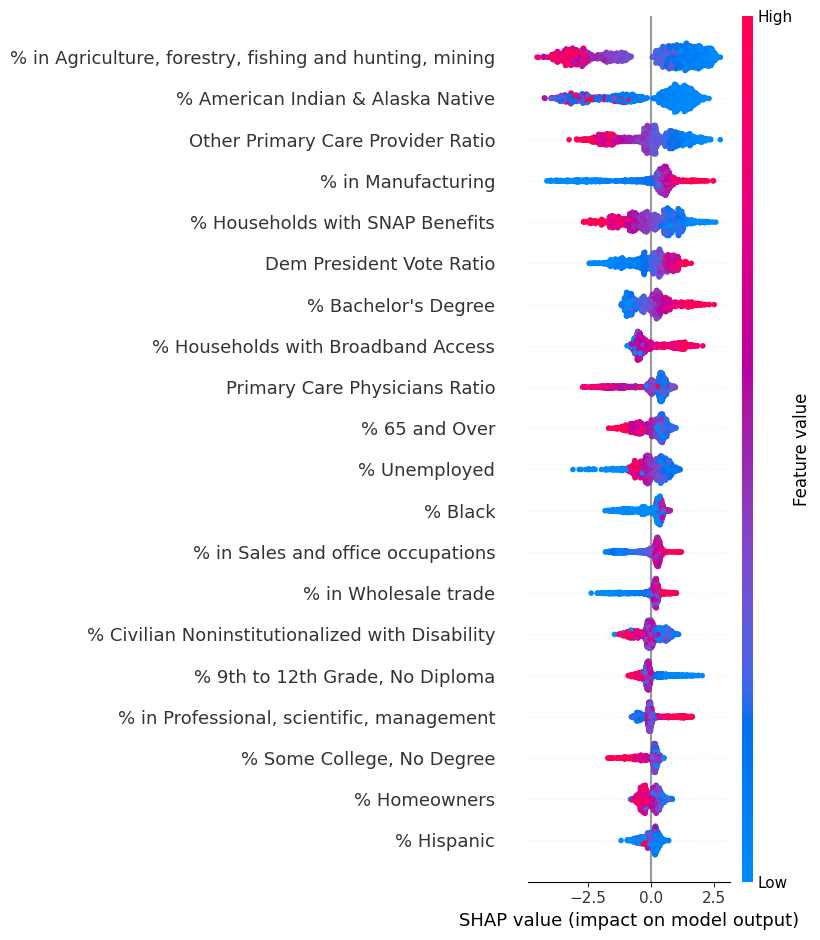

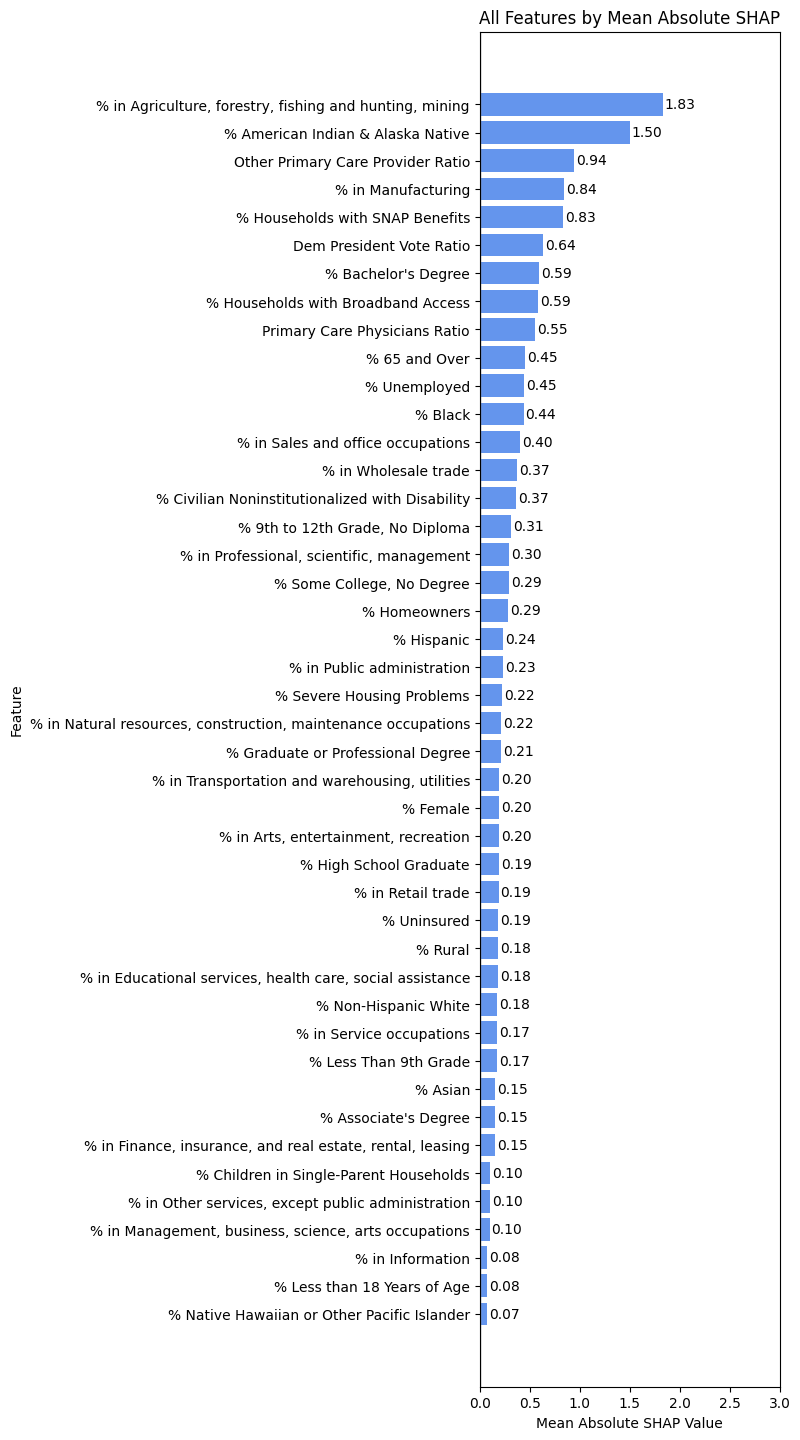

Top 5 Features


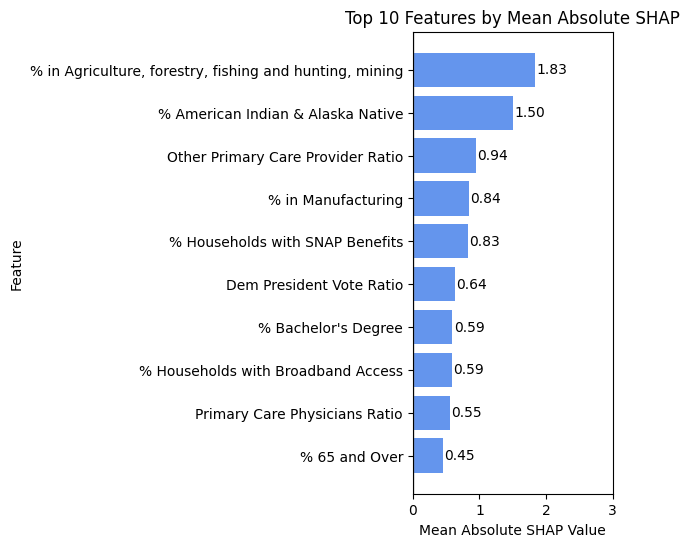

In [33]:
result6 = MC('/Users/jacobhahn/Desktop/CSUREMM 2025/DURING_COVID_ind_rural.xlsx')

# Post COV Analysis on URBAN/MIXED/RURAL


🔍 Trial 1/50 with params: {'n_estimators': np.int64(300), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.03), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.1), 'reg_alpha': np.float64(0.0), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 4.97, Avg R²: 0.63, Avg MAPE: 8.64%

🔍 Trial 2/50 with params: {'n_estimators': np.int64(300), 'max_depth': np.int64(2), 'learning_rate': np.float64(0.05), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.6), 'gamma': np.float64(0.5), 'reg_alpha': np.float64(0.1), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 5.11, Avg R²: 0.60, Avg MAPE: 8.92%

🔍 Trial 3/50 with params: {'n_estimators': np.int64(300), 'max_depth': np.int64(2), 'learning_rate': np.float64(0.05), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.3), 'reg_alpha': np.float64(0.0), 'reg_lambda': np.int64(1)}
✅ Avg RMSE: 5.13, Avg R²: 0.60, Avg MAPE: 8.97%

🔍 Trial 4/50 with params: {'n_estimators': np

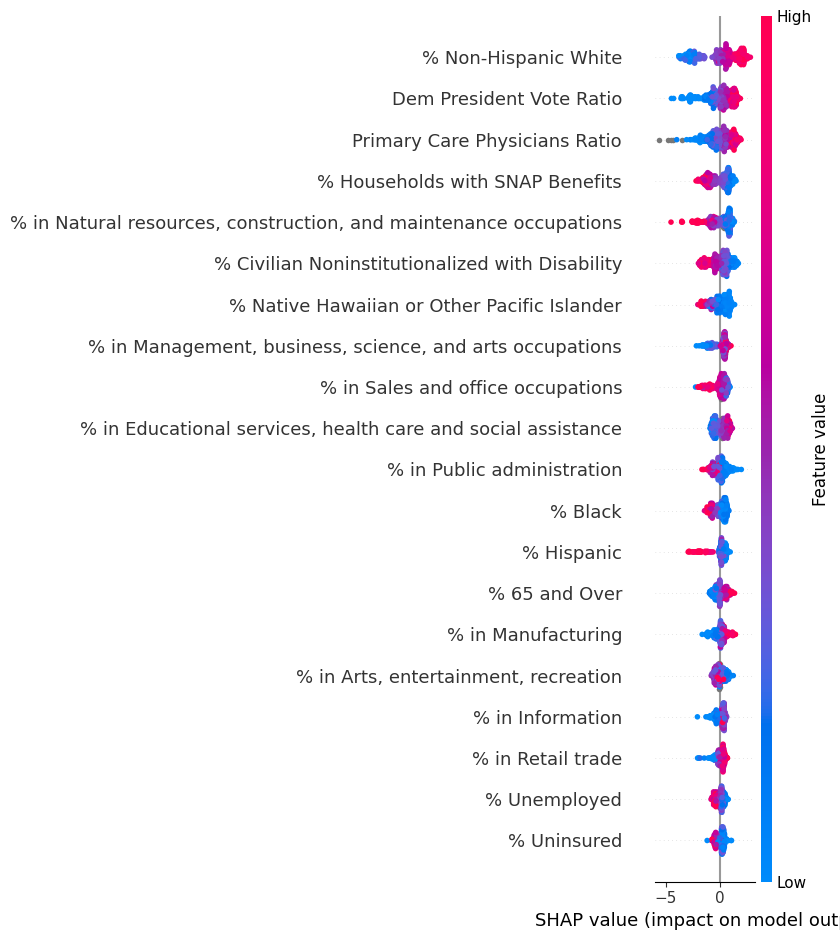

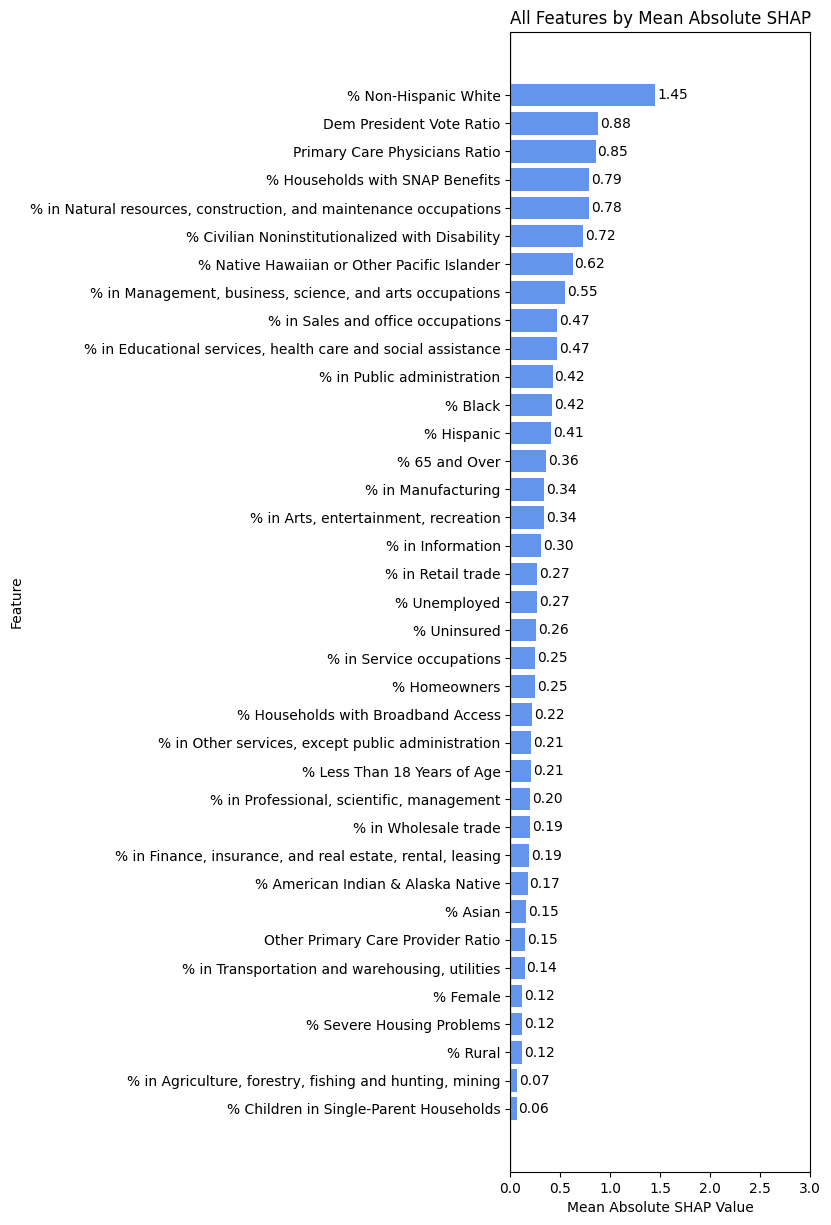

Top 5 Features


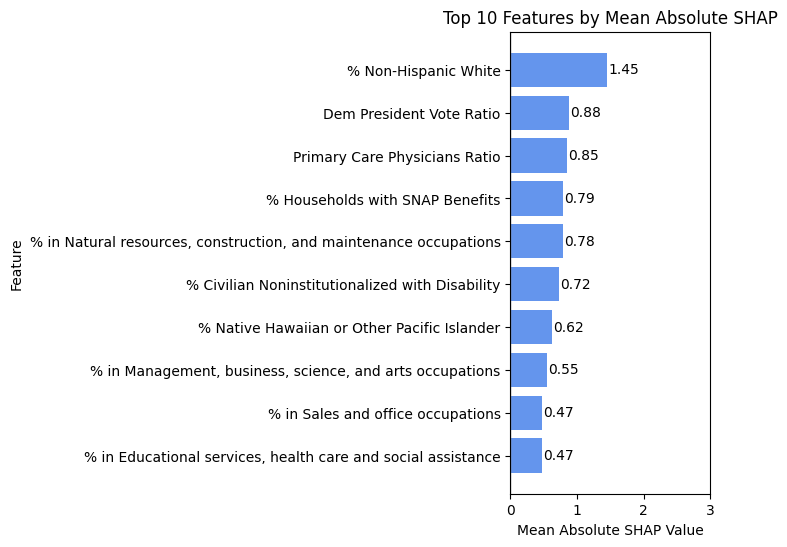

In [34]:
result7 = MC('/Users/jacobhahn/Desktop/CSUREMM 2025/POST_COVID_ind_urban.xlsx')


🔍 Trial 1/50 with params: {'n_estimators': np.int64(300), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.3), 'reg_alpha': np.float64(0.1), 'reg_lambda': np.int64(1)}
✅ Avg RMSE: 6.17, Avg R²: 0.48, Avg MAPE: 12.29%

🔍 Trial 2/50 with params: {'n_estimators': np.int64(200), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.1), 'reg_alpha': np.float64(0.5), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 6.38, Avg R²: 0.45, Avg MAPE: 12.84%

🔍 Trial 3/50 with params: {'n_estimators': np.int64(100), 'max_depth': np.int64(2), 'learning_rate': np.float64(0.03), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.6), 'gamma': np.float64(0.3), 'reg_alpha': np.float64(0.1), 'reg_lambda': np.int64(5)}
✅ Avg RMSE: 6.54, Avg R²: 0.42, Avg MAPE: 13.13%

🔍 Trial 4/50 with params: {'n_estimators':

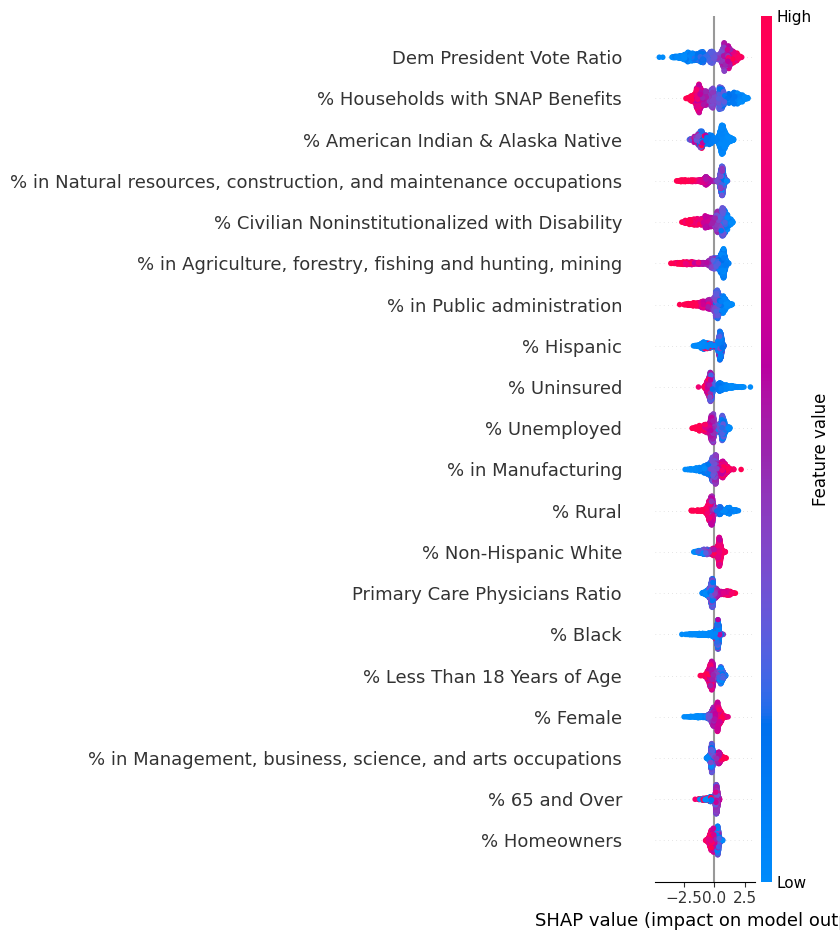

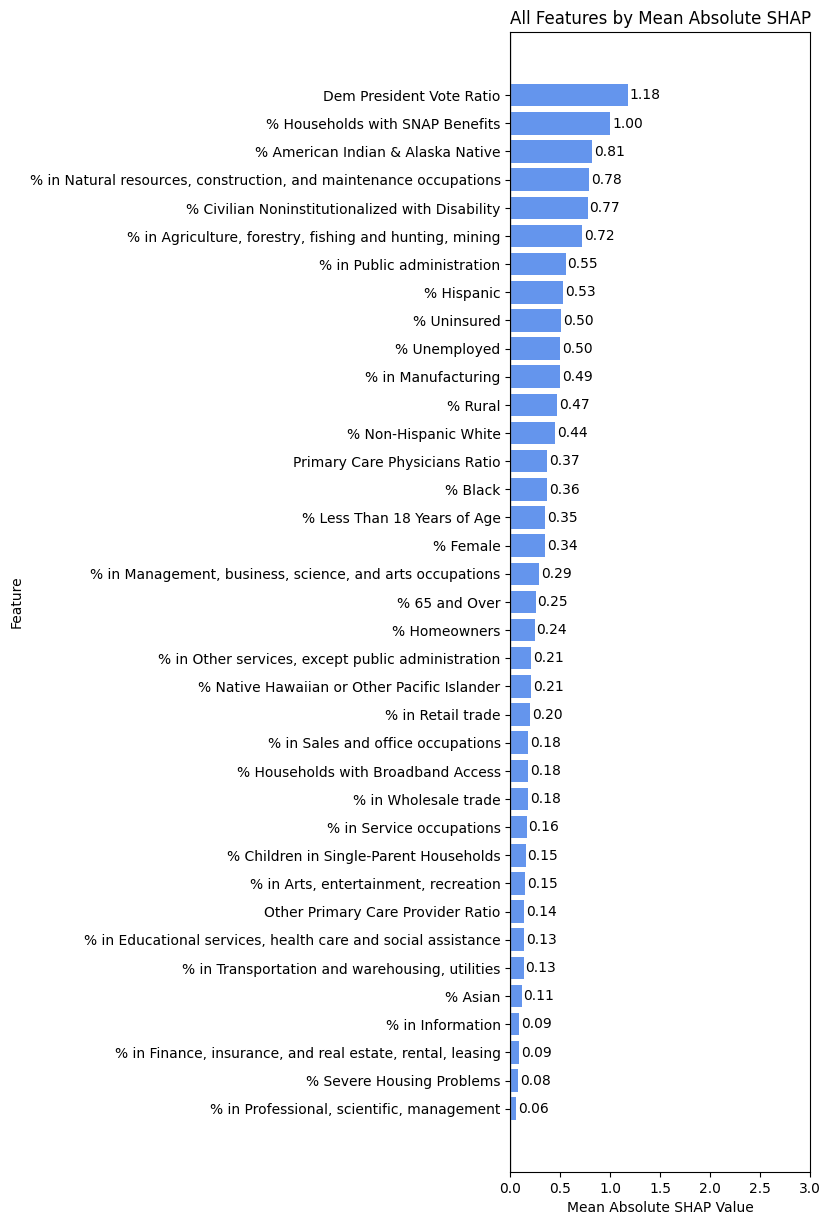

Top 5 Features


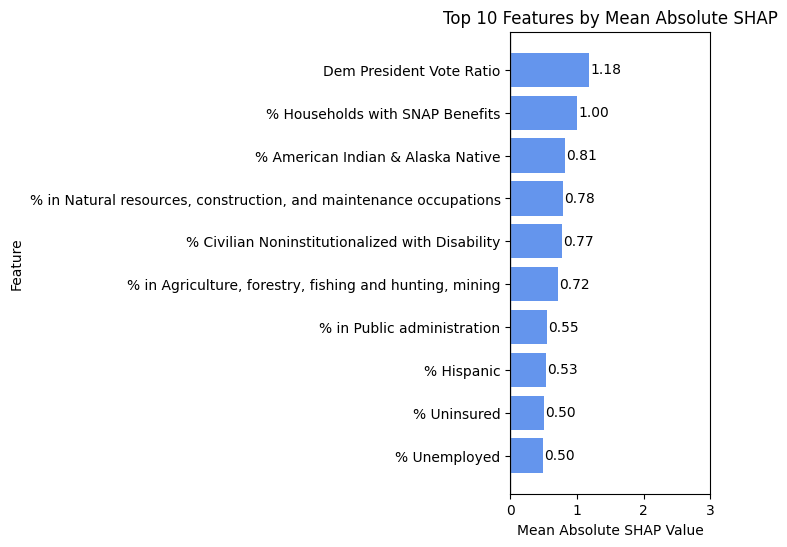

In [35]:
result8 = MC('/Users/jacobhahn/Desktop/CSUREMM 2025/POST_COVID_ind_mix.xlsx')


🔍 Trial 1/50 with params: {'n_estimators': np.int64(300), 'max_depth': np.int64(3), 'learning_rate': np.float64(0.03), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.6), 'gamma': np.float64(0.1), 'reg_alpha': np.float64(0.0), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 8.35, Avg R²: 0.32, Avg MAPE: 25.61%

🔍 Trial 2/50 with params: {'n_estimators': np.int64(100), 'max_depth': np.int64(2), 'learning_rate': np.float64(0.05), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.5), 'reg_alpha': np.float64(0.5), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 8.43, Avg R²: 0.31, Avg MAPE: 26.23%

🔍 Trial 3/50 with params: {'n_estimators': np.int64(200), 'max_depth': np.int64(2), 'learning_rate': np.float64(0.01), 'subsample': np.float64(0.6), 'colsample_bytree': np.float64(0.8), 'gamma': np.float64(0.5), 'reg_alpha': np.float64(0.5), 'reg_lambda': np.int64(2)}
✅ Avg RMSE: 8.73, Avg R²: 0.26, Avg MAPE: 27.57%

🔍 Trial 4/50 with params: {'n_estimators':

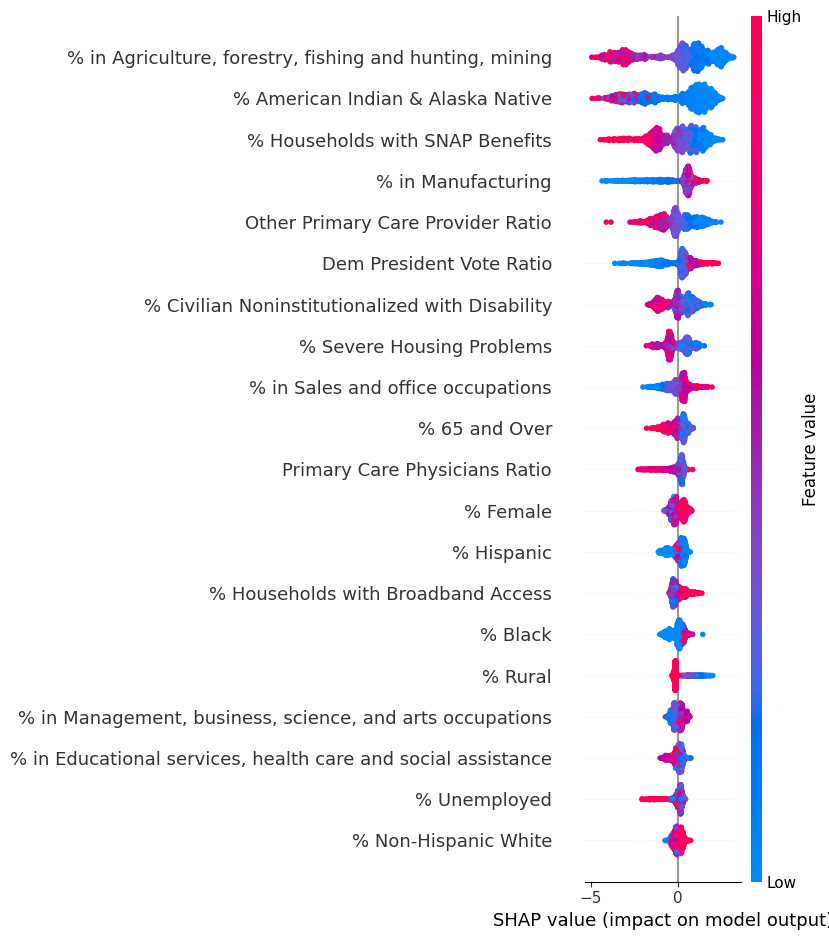

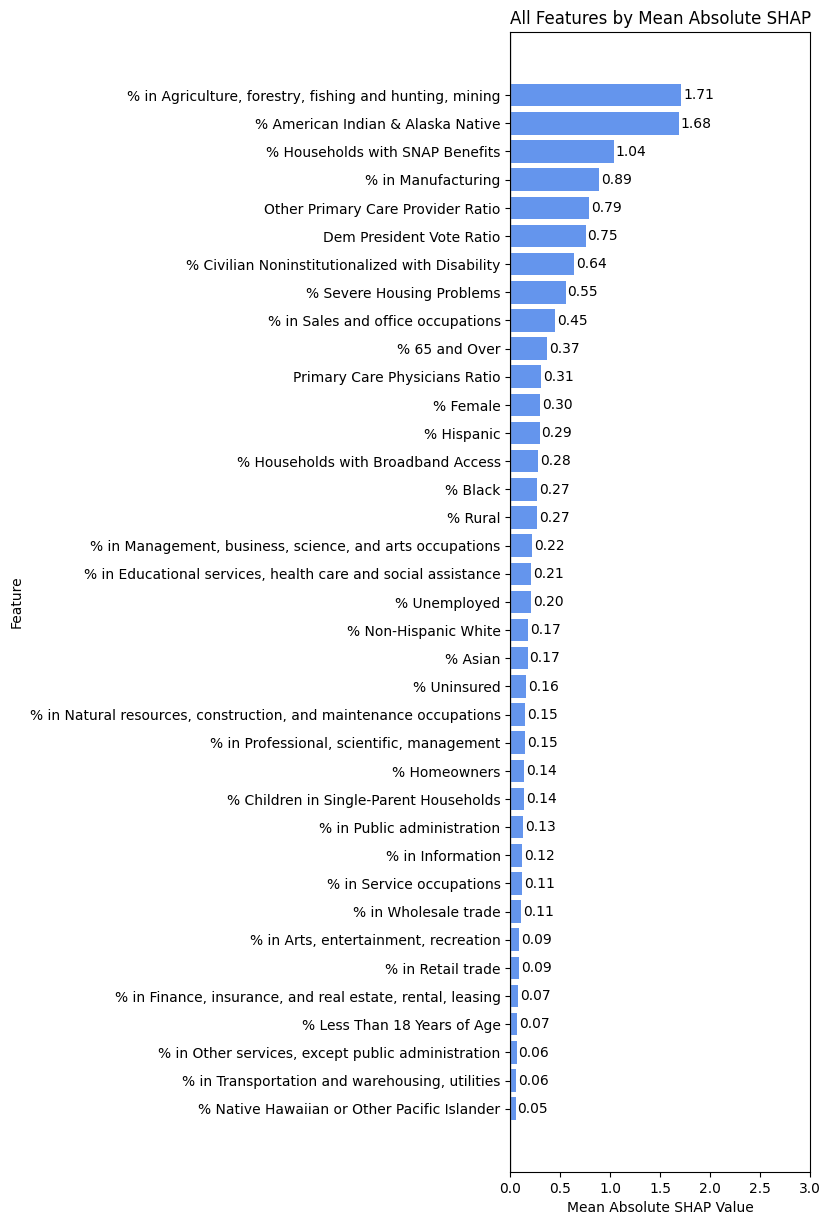

Top 5 Features


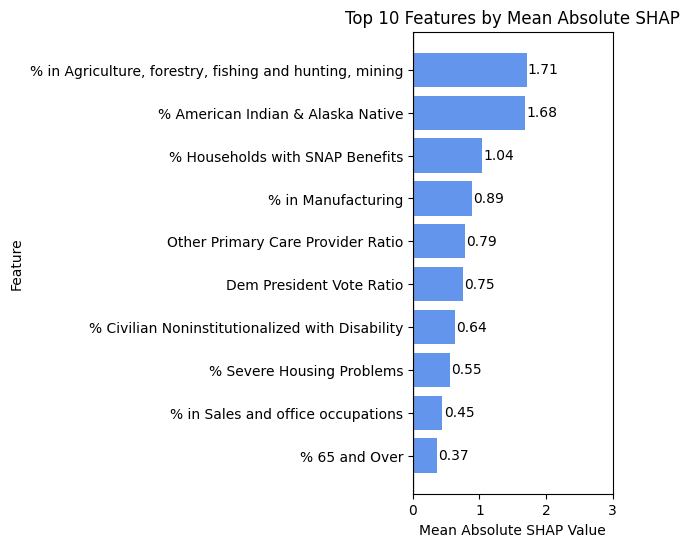

In [36]:
result9 = MC('/Users/jacobhahn/Desktop/CSUREMM 2025/POST_COVID_ind_rural.xlsx')